# APRENDIZAJE AUTOMÁTICO
# Práctica 2: Regularización y Selección de Modelos
### Autor: Jiménez Omeñaca, David
### NIP:   825068   
### Fecha: 15-02-2025
---



## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = 'data/'                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

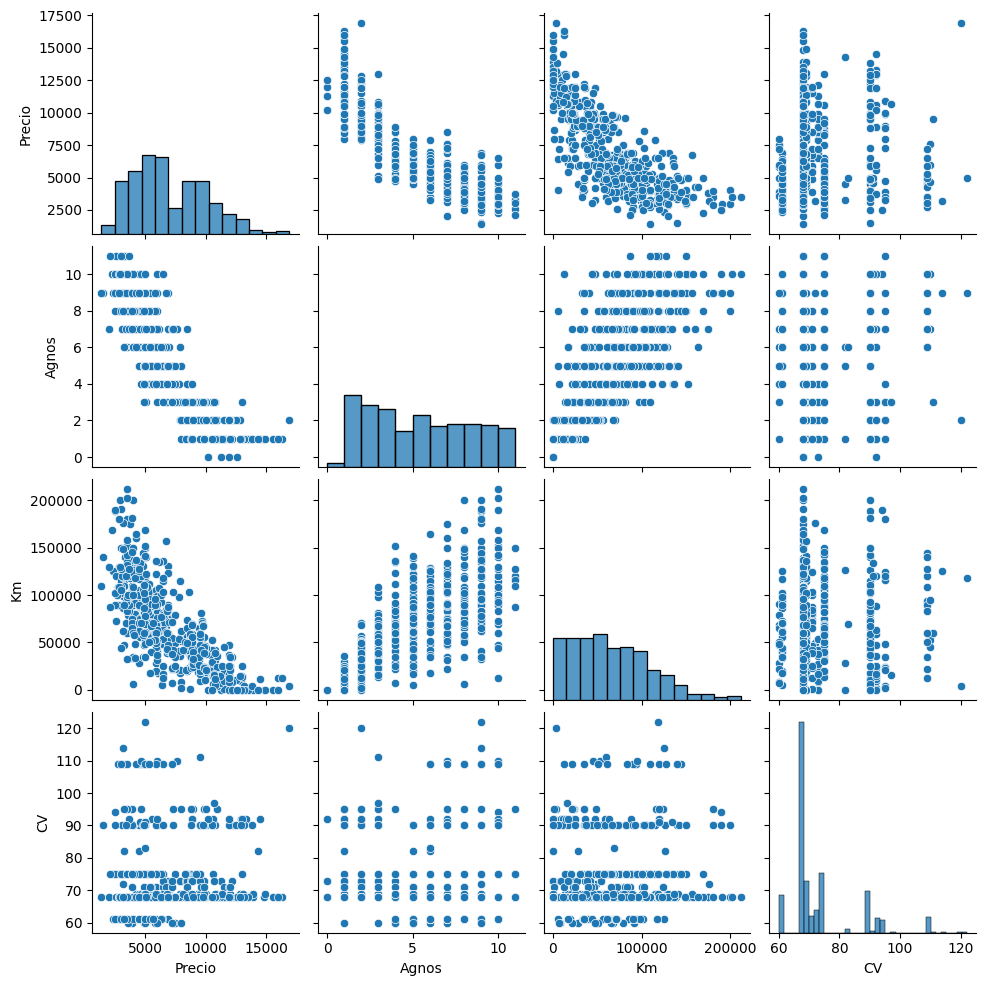

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

plt.close('all')

# Leer los ficheros de datos y pasarlos a matrices de numpy
coches_train = pd.read_csv(Path+'CochesTrain.csv', sep = ";")
x1_train = coches_train["Agnos"].to_numpy().reshape(-1, 1)
x2_train = coches_train["Km"].to_numpy().reshape(-1, 1)
x3_train = coches_train["CV"].to_numpy().reshape(-1, 1)
y_train  = coches_train["Precio"].to_numpy()

coches_test  = pd.read_csv(Path+'CochesTest.csv',  sep = ";")
x1_test = coches_test["Agnos"].to_numpy().reshape(-1, 1)
x2_test = coches_test["Km"].to_numpy().reshape(-1, 1)
x3_test = coches_test["CV"].to_numpy().reshape(-1, 1)
y_test  = coches_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(coches_train)
plt.show()

Analizando las diferentes variables presentes en el programa, llegamos a las siguientes conclusiones:
- Tenemos 3 **covariables** referentes a coches: años de antigûedad `Agnos` , kilómetros recorridos `Km` y la potencia en `Caballo de Vapor` o `CV` con las que queremos explicar el precio en € del vehículo `Precio`.
- Todas las covariables tienen una distribución casi uniforme en todo su dominio excepto los caballos.
- Las unidades de medida de estas variables son totalemente diferente, unas con rango de $[0,12]$ y otras con rangos de  $[0, 2\cdot 10^5]$.
- Se ve una clara dependencia inversa entre el precio y el número de años y kilómetros. Sin embargo, en principio, no se detecta una relación aparente entre la potenciay el precio (puede estar *opacada* por el resto de variables)
- Respecto a las covariables, se detectar una clara dependencia directa entre los kilómetros y los años, algo que tiene sentido.

Para analizar mejor esta dependencia, vamos a imprimir la matriz de covarianzas entre las tres covariables.

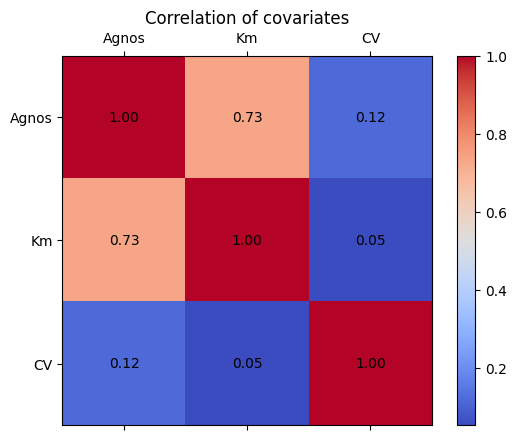

In [3]:
data = np.concatenate([x1_train, x2_train, x3_train], axis=1)
corr_matrix = np.corrcoef(data.transpose())

fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='coolwarm')

# Add the value of each cell in text in the center of the cell
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set the ticks and labels
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(["Agnos", "Km", "CV"])
ax.set_yticklabels(["Agnos", "Km", "CV"])

# Add a title
plt.title("Correlation of covariates")

plt.colorbar(cax)
plt.show()


Aquí confirmamos la fuerte correlación que habíamos detectado entre kilómetros y años al analizar las gráficas. Nuestro estudio tendrá que **tener en cuenta esta correlación**.

Antes de comenzar, se va a explicar una serie de aspectos generales de cómo se van a analizar los modelos:
- Para evitar problemas en la regularización y en el ajuste polinómico, se van a normalizar las covariables al dominio $[-1,1]$.
- Se van a calcular solo la medida `RMSE`. 
- Para el código de medidas y comparación de modelos, se va a utilizar una adaptación del código presentado en la práctica $1$, que se va a exponer a continuación.

In [4]:
from enum import IntFlag
import pandas as pd
from typing import Dict

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ErrorMetricsFlags(IntFlag):
    """
    Class to represent which error metrics to compute in a Linear Regression 
    analysis.

    It supports:

    - **RMSE**: Root Mean Squared Error 
    - **MAE**: Mean Absolute Error
    - **MedAE**: Median Absolute Error
    - **MRE**: Mean Relative Error
    - **MedRE**: Median Relative Error
    - **R2**: Coefficient of Determination (R^2)
    """

    RMSE = 1 << 0
    MAE = 1 << 1
    MedAE = 1 << 2
    MRE = 1 << 3
    MedRE = 1 << 4
    R2 = 1 << 5


class ErrorMetrics():
    """
    A class to compute various error metrics for model evaluation.
    """

    def __init__(self, y_real:np.ndarray, y_pred:np.ndarray) -> None:
        """
        Initializes the ErrorMetrics class with the real and predicted values.

        Parameters
        ----------

        y_real (np.ndarray) : The real values of the target variable.
        y_pred (np.ndarray) : The predicted values of the target variable.

        """
        self.y_real = y_real
        self.y_pred = y_pred
        self.n = y_real.shape[0]
    def RMSE(self) -> float:
        """ 
        Function to compute the Root Mean Squared Error (RMSE) of the model.
        """
        return np.sqrt(1/self.n*np.sum(np.pow((self.y_pred-self.y_real),2)))
    def MAE(self) -> float:
        """
        Function to compute the Mean Absolute Error (MAE) of the model.
        """
        return 1.0/self.n*sum(np.abs(self.y_pred-self.y_real))
    def MedAE(self) -> float:
        """ 
        Function to compute the Median Absolute Error (MedAE) of the model.
        """
        return np.median(np.abs(self.y_pred-self.y_real))
    def MRE(self) -> float:
        """
        Function to compute the Mean Relative Error (MRE) of the model.
        """
        return 1/self.n*np.sum(np.abs(self.y_pred-self.y_real)/self.y_real)
    def medRE(self) -> float:
        """
        Function to compute the Median Relative Error (MedRE) of the model.
        """
        return np.mean(np.abs(self.y_pred-self.y_real)/self.y_real)
    def R2(self) -> float:
        """
        Function to compute the Coefficient of Determination (R^2) of the model.
        """
        a = (self.y_real-self.y_pred).transpose() @ (self.y_real-self.y_pred)
        b = (self.y_real-np.mean(self.y_real)).transpose() @ (self.y_real-np.mean(self.y_real))
        return 1-a/b
    
    def compute_metrics(self, flags:ErrorMetricsFlags, name:str, r:int) -> Dict[str, float]:
        """
        Function to compute multiple error metrics at once.

        Parameters
        ----------

        flags (ErrorMetricsFlags) : The flags indicating which metrics to compute.
        name (str) : The name of the model.

        Returns
        -------

        dict (Dict[str, float]) : A dictionary containing the computed metrics (given by the activated flags).
        """
        dic_ = {
            f'RMSE_{name}': [round(self.RMSE(), r)] if flags & ErrorMetricsFlags.RMSE else [],
            f'MAE_{name}': [round(self.MAE(), r)] if flags & ErrorMetricsFlags.MAE else [],
            f'MedAE_{name}': [round(self.MedAE(), r)] if flags & ErrorMetricsFlags.MedAE else [],
            f'MRE_{name}': [round(self.MRE(), r)] if flags & ErrorMetricsFlags.MRE else [],
            f'MedRE_{name}': [round(self.medRE(), r)] if flags & ErrorMetricsFlags.MedRE else [],
            f'R2_{name}': [round(self.R2(), r)] if flags & ErrorMetricsFlags.R2 else []
        }
        return dic_

class LinearRegression:
    """
    Class to represent a Linear Regression model which can be trained and evaluated.
    """
    def __init__(   self, train_x:np.ndarray, train_y:np.ndarray,
                    test_x:np.ndarray, test_y:np.ndarray, model, name:str,
                    metrics:ErrorMetricsFlags):
        """
        Initializes the LinearRegression class with the training and testing data.

        Parameters
        ----------
        train_x (np.ndarray) : The training input data.
        train_y (np.ndarray) : The training target data.
        test_x (np.ndarray) : The testing input data.
        test_y (np.ndarray) : The testing target data.
        model : The model to be trained.
        name (str) : The name of the model.
        metrics (ErrorMetricsFlags) : The error metrics to compute.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.model = model
        self.name = name
        self.metrics = metrics

        # Fit the model
        self.model.fit(self.train_x, self.train_y)



    def plot_pred_vs_real(self, title=""):

        """
        Function to plot the predicted vs real values of the model.
        It also plots the line y=x.

        Parameters
        ----------

        title (str, optional) : The title of the plot. Defaults to "".
        """
        plt.figure()

        plt.plot(self.test_y, self.model.predict(self.test_x), 'bx', label="Test")
        plt.plot(self.train_y, self.model.predict(self.train_x), 'gx', label="Train")

        # Create a grid to plot a line
        all_values = np.concat([self.test_y,self.train_y],axis=0)
        x_grid = np.linspace(np.min(all_values), np.max(all_values), 100).reshape(-1, 1)
        plt.plot(x_grid, x_grid, 'k-', label='y=x')

        plt.xlabel("Real")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.legend()
        plt.grid()

    def compute_metrics(self, r=2):

        """
        Function to compute the metrics of the model.

        Parameters
        ----------
        r (int, optional) : The number of decimals to round the metrics. Defaults to 2.

        Returns
        -------

        pd.DataFrame : A DataFrame containing the computed metrics.
        """

        y_train_predicted = self.model.predict(self.train_x)
        y_test_predicted = self.model.predict(self.test_x)

        # Compute the metrics for training
        em_train = ErrorMetrics(y_train, y_train_predicted)
        metrics_train = em_train.compute_metrics(self.metrics, "train", r)

        em_test = ErrorMetrics(y_test, y_test_predicted)
        metrics_test = em_test.compute_metrics(self.metrics, "test", r)

        metrics = {"Name":self.name,**metrics_train, **metrics_test}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)

In [5]:
# Create a empty models
models = Models()

# Create wanted flags
flags = ErrorMetricsFlags.RMSE


----
## 1. Regresión Lineal

Realizamos un primer modelo de regresión lineal básica utilizando las fórmulas normales, para ajustar el precio respecto a las **tres covariables**.

,Name,RMSE_train,RMSE_test
0,Basic Linear Regression,1315.23,1232.98


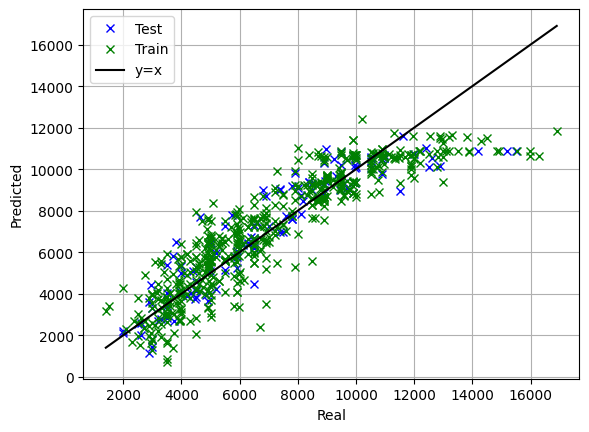

In [6]:
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

x_train = np.concatenate([x1_train, x2_train, x3_train], axis=1)
x_test = np.concatenate([x1_test, x2_test, x3_test], axis=1)

mod_1 = make_pipeline(MinMaxScaler(feature_range=(-1,1)), linear_model.LinearRegression())

model_1 = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    mod_1, "Basic Linear Regression",
    flags
)

models.append(model_1.compute_metrics())

model_1.plot_pred_vs_real()
model_1.compute_metrics()

En la gráfica de valores reales vs predichos, observamos que los puntos se ajustan bien al principio mas llega un punto en el que siguen un patrón concreto. Así, los resíduos no son homogéneos, lo que puede estar indicándonos que es posible que una regresión con términos polinómicos sea más adecuada. 

----
## 2. Selección del grado del polinomio


Para realizar un ajuste polinómico hay que decidir hasta que grado se va a tomar. Es decir, necesitamos obtener un hiperparámetro $\sigma\in [0,10]$ que sea el grado máximo del polinomio que se va a tomar
$$
y = \theta_0 + \theta_{11} x_1 + \theta_{12} x_2 + \theta_{13} x_3 + \cdots + \theta_{\sigma 1} x_1^\sigma + \theta_{\sigma 2} x_2^\sigma + \theta_{\sigma 3} x_3^\sigma
$$

donde $x_1$ es la antigüedad del coche, $x_2$ son los kilómetros recorridos y $x_3$ es la potencia. Para elegir el valor de este hiperparámetro, se tienen que dividir los datos de training en datos de train y validación. Así, para cada valor elegido del hiperparámetro, se entrenará un modelo con estos nuevos datos de training y se calcularán las medidas de error con los datos de validación, eligiendo el valor con menor error. 

Una mejor versión de este método es dividir los datos en $K$ *folds* o partes y ajustar cada modelo $K$ veces, tomando un *fold* distinto cada vez. Esto es lo que se conoce como **K-Fold Cross Validation** y permite reducir el impacto de la selección de los datos de validación. 

En la librería [`sklearn`](https://scikit-learn.org/stable/modules/cross_validation.html) hay funciones que permiten realizar esto directamente pero con fines educativos se va a implementar solo utilizando la función de división en **folds** llamada `KFold.split()`. 

Para la validación cruzada se va a seguir el esqueda dado en clase. Para ello, se va a crear una clase que realize este procedimiento

In [44]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

class KValidation():
    def __init__(self, x_train, y_train, model_factory, hyperparameters_range, folds=5):
        self.x_train = x_train
        self.y_train = y_train
        self.folds = folds
        self.kf = KFold(n_splits=folds, shuffle=True, random_state=1)
        self.model_factory = model_factory
        self.hyperparameters_range = hyperparameters_range
        self.training_errors = []
        self.validation_errors = []
    
    def compute_errors(self):

        RMSE = lambda x,y : np.sqrt(1/x.shape[0]*np.mean(np.pow((x-y),2)))

        for hyperparameter in self.hyperparameters_range:
            t_error = 0
            v_error = 0
            model = self.model_factory(hyperparameter)

            scores = cross_validate(model, x_train, y_train, cv=self.kf, scoring='neg_mean_squared_error', return_train_score=True)
            self.training_errors.append(-np.mean(scores['train_score']))
            self.validation_errors.append(-np.mean(scores['test_score']))
            # for i, (train_index, validation_index) in enumerate(self.kf.split(self.x_train, self.y_train)):
            #     x_train_,y_train_ = self.x_train[train_index,:], self.y_train[train_index]
            #     x_validation,y_validation = self.x_train[validation_index,:], self.y_train[validation_index]

            #     model.fit(x_train_, y_train_)

            #     y_train_pred = model.predict(x_train_)
            #     y_validation_pred = model.predict(x_validation)

            #     t_error += RMSE(y_train_, y_train_pred)
            #     v_error += RMSE(y_validation, y_validation_pred)

            # self.training_errors = self.training_errors + [float(t_error/self.kf.get_n_splits())]
            # self.validation_errors = self.validation_errors + [float(v_error/self.kf.get_n_splits())]
    def plot_errors(self, x_label="Hyperparameter", title="Training and Validation Errors vs Hyperparameter values",  log = False):
        if log:
            plt.plot(self.hyperparameters_range, np.log(self.training_errors), "b-", label="Training Error")
            plt.plot(self.hyperparameters_range, np.log(self.validation_errors), "r-", label="Validation Error")
            plt.ylabel("Log of RMSE")
        else:
            plt.plot(self.hyperparameters_range, self.training_errors, "b-", label="Training Error")
            plt.plot(self.hyperparameters_range, self.validation_errors, "r-", label="Validation Error")
            plt.ylabel("RMSE")
        plt.title(title) 
        
        plt.xlabel(x_label)
        plt.legend()
        plt.grid()
    
    def get_best_hyperparameter(self):
        return self.hyperparameters_range[np.argmin(self.validation_errors)]
    
    def get_best_model(self):
        best_hyperparameter = self.get_best_hyperparameter()
        return self.model_factory(best_hyperparameter)


Ahora, se va a realizar el ajuste para los valores del grado del polinomio, ploteando una gráfica con los errores de validación y entrenamiento respecto al grado (complejidad) del modelo.

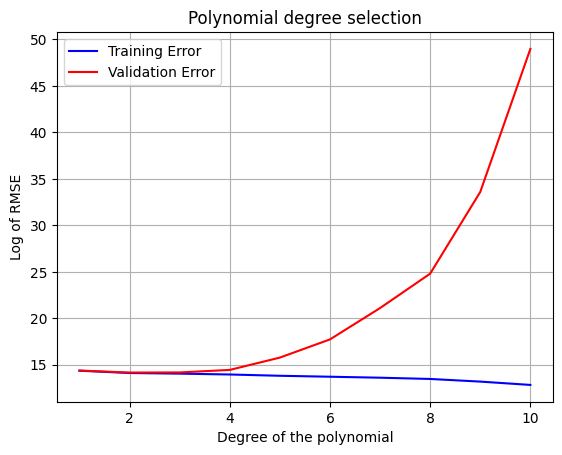

In [45]:
# Model creator. Lambda function that given a degree n, it gives a polynomial regression model
mod_2_factory = lambda n : make_pipeline(
        MinMaxScaler(feature_range=(-1,1)),
        PolynomialFeatures(n),
        linear_model.LinearRegression()
    )

# Hyperparameters range
hyperparameters_range = range(1, 11)

# Create the KValidation object
kv = KValidation(x_train, y_train, mod_2_factory, hyperparameters_range)

# Compute the errors
kv.compute_errors()

# Plot the errors
kv.plot_errors(x_label="Degree of the polynomial", title="Polynomial degree selection", log=True)

Aquí, podemos ver un claro sobreajuste cuando $k>4$ ya que el error de validación crece cuando la complejidad del modelo aumenta. Ahora, seleccionamos el grado que minimiza el **RMSE**.

In [46]:
print("Best-Degree:", kv.get_best_hyperparameter())

best_model_pol = kv.get_best_model()

Best-Degree: 2


Así obtenemos que el mejor modelo según el **K-Cross Validation** realizado es el de grado $\sigma=2$. Ahora ajustamos el modelo con los datos de entrenamiento y test iniciales.

,Name,RMSE_train,RMSE_test
0,Polynomial Regression of degree 2,1164.7,1132.26


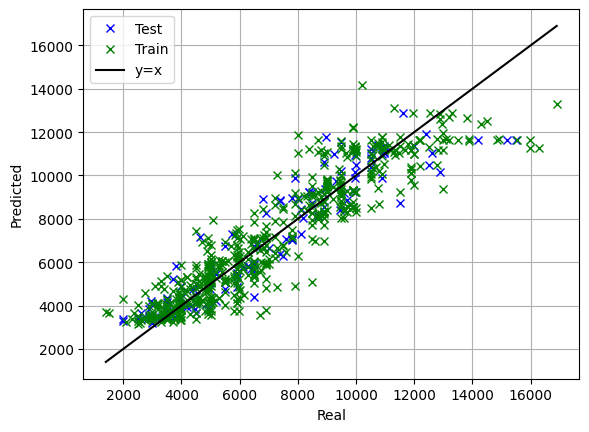

In [47]:
model_2 = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    best_model_pol, f"Polynomial Regression of degree {kv.get_best_hyperparameter()}",
    flags
)

models.append(model_2.compute_metrics())

model_2.plot_pred_vs_real()
model_2.compute_metrics()

Aquí podemos ver una notable mejora repecto al modelo anterior, ya que ahora los errores parecen menos sesgados.

----
## 2. Selección del parámetro de regularización

Ahora vamos a aplicar la misma técnica para obtener el valor óptimo del parámetro de regularización $\lambda$ que penaliza en función de qué tan grandes sean los pesos $\theta$. Hay que tener en cuenta que, cuanto mayor sea este parámetro, va a ocurrir lo que se conoce como **sub-ajuste** ya que los pesos estarán tán penalizados que muchos de ellos serán próximos a cero, teniendo un modelo muy poco complejo que es incapaz de ajustar el modelo. Sin embargo, si el valor de $\lambda$ es muy pequeño, puede ocurrir lo que se conoce como **sobre-ajuste** ya que no se están penalizado los pesos del modelo, obteniendo una complejidad muy alta. Hay dos tipos de regularización principales: la **regularización L1** que pondera los errores en valor absoluto y la **regularización L2** que lo hace cuadráticamente.
$$
\begin{align}
y =& \cdots + \lambda \sum_i |\theta_i| &\text{(L1)} \\
y =& \cdots + \lambda \sum_i \theta_i^2 &\text{(L2)}
\end{align}

$$

Vamos a aplicar esta técnica sobre el modelo polinómico de grado máximo 10, utilizando la clase anterior. Empezemos primero con el modelo con regularización **L1** o **Lasso**:


In [48]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Lasso, Ridge

# Model creator. Lambda function that given a value of lambda l, it gives a Lasso model with that coefficient
mod_3_factory_lasso = lambda l : make_pipeline(
        PolynomialFeatures(10),
        MinMaxScaler(feature_range=(-1,1)),
        linear_model.Lasso(alpha=l, max_iter=10000, )
)

# Model creator. Lambda function that given a value of lambda l, it gives a Ridge model with that coefficient
mod_3_factory_ridge = lambda l : make_pipeline(
        PolynomialFeatures(10),
        MinMaxScaler(feature_range=(-1,1)),
        linear_model.Ridge(alpha=l, max_iter=10000)
)

l_range = np.logspace(-4, 0.5, 10)

kv_lasso = KValidation(x_train, y_train, mod_3_factory_lasso, l_range)
kv_ridge = KValidation(x_train, y_train, mod_3_factory_ridge, l_range)

kv_lasso.compute_errors()
kv_ridge.compute_errors()

c:\Users\david\Desktop\Automatic-Learning\Lab-01\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e+08, tolerance: 4.070e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\Desktop\Automatic-Learning\Lab-01\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+08, tolerance: 3.985e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\Desktop\Automatic-Learning\Lab-01\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Best lambda L1:  1.0


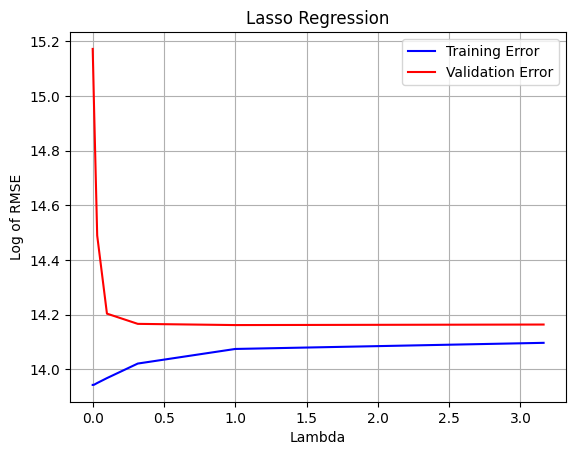

In [49]:
kv_lasso.plot_errors(x_label="Lambda", title="Lasso Regression", log=True)
print("Best lambda L1: ", kv_lasso.get_best_hyperparameter())

Realizamos lo mismo con la regularización **L2** o **Ridge**:

Best lambda L2:  1.0


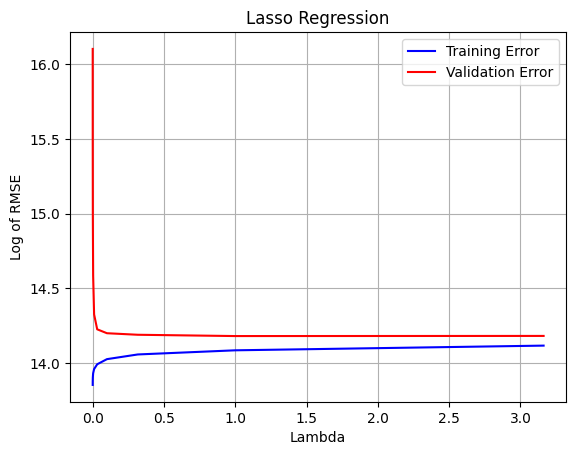

In [ ]:
kv_ridge.plot_errors(x_label="Lambda", title="Ridge Regression", log=True)
print("Best lambda L2: ", kv_ridge.get_best_hyperparameter())

Ahora añadimos los dos mejores modelos y calculamos sus métricas:

In [51]:
model_3_lasso = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    kv_lasso.get_best_model(), f"Lasso Regression with lambda {kv_lasso.get_best_hyperparameter()}",
    flags
)

model_3_ridge = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    kv_ridge.get_best_model(), f"Ridge Regression with lambda {kv_ridge.get_best_hyperparameter()}",
    flags
)

# Add models
models.append(model_3_lasso.compute_metrics())
models.append(model_3_ridge.compute_metrics())


pd.concat([model_3_lasso.compute_metrics(), model_3_ridge.compute_metrics()], axis=0)

,Name,RMSE_train,RMSE_test
0,Lasso Regression with lambda 1.0,1144.38,1130.31
0,Ridge Regression with lambda 1.0,1147.15,1136.74


En ambas gráficas podemos observar un sobreajuste al comienzo, debido a que el coeficiente de regularización es muy pequeño. Sin embargo, al aumentar el cofiente, se regulariza el modelo, disminuyendo así el sobreajuste. Además, no se aprecia ninguna diferencia aparente en las métricas de error entre ambos tipos de regularización.

----
## 4. Modelos neuronales

Vamos a probar ahora a ajustar nuestro modelo utilizando una red neuronal sin capa oculta y otra con una capa oculta de $100$ neuronas. Comenzamos con la red neuronal sin capa oculta. Para la convergencia ha sido necesario utilizar el optimizador `SGD`.

,Name,RMSE_train,RMSE_test
0,Neural Network without hidden layers,1315.38,1231.45


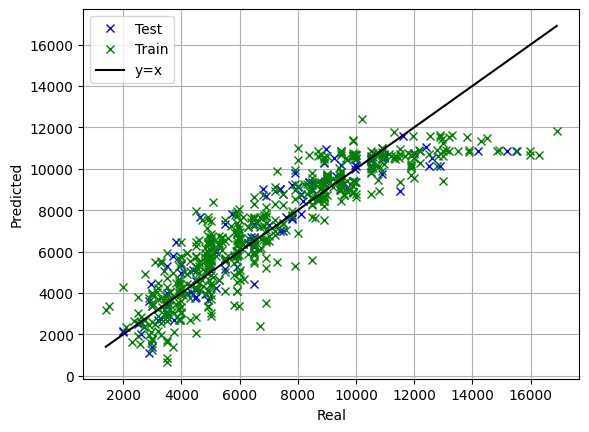

In [52]:
from sklearn.neural_network import MLPRegressor

mod_nn_no_hidden = make_pipeline(
    MinMaxScaler(feature_range=(-1,1)),
    MLPRegressor(hidden_layer_sizes=(), max_iter=10000, solver='sgd')
)

model_4_nh = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    mod_nn_no_hidden, 
    "Neural Network without hidden layers",
    flags
)

models.append(model_4_nh.compute_metrics())

model_4_nh.plot_pred_vs_real()
model_4_nh.compute_metrics()

Aquí, problemas similares al modelo linear aparecen debido a que no hay capa oculta. Añadiéndola, obtenemos el siguiente modelo

,Name,RMSE_train,RMSE_test
0,Neural Network with a hidden layers of 100 neu...,1315.33,1231.73


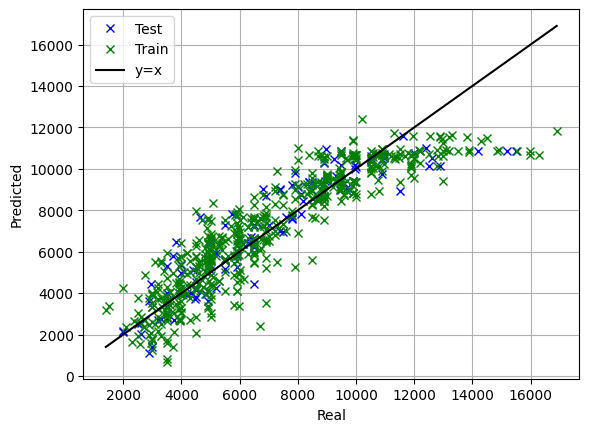

In [53]:
from sklearn.neural_network import MLPRegressor

mod_nn_hidden = make_pipeline(
    MinMaxScaler(feature_range=(-1,1)),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=10000)
)

model_4_h = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    mod_nn_no_hidden, 
    "Neural Network with a hidden layers of 100 neurons",
    flags
)

models.append(model_4_h.compute_metrics())

model_4_h.plot_pred_vs_real()
model_4_h.compute_metrics()

Aquí podemos apreciar que ninguna de las dos redes han sido capaces de capturar la tendencia no lineal de la red, obteniendo residuos no uniformes en la cola derecha. Además, ambos han obtenido resultados similares.

---
## 5. Modelos neuronales con regularización

En esta sección vamos a realizar algo similar al apartado 3 pero ahora sobre una red neuronal con $100$ neuronas en la capa oculta. En este caso, solo lo realizaremos con la regularización L2.


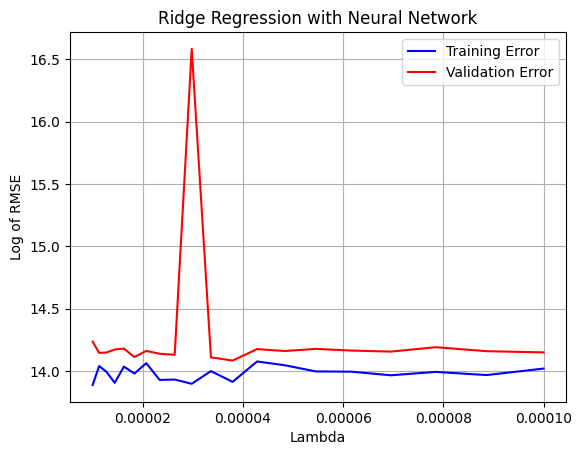

In [95]:
mod_5_factory_l2 = lambda l : make_pipeline(
        MinMaxScaler(),
        MLPRegressor(hidden_layer_sizes=(100, ), max_iter=10000, alpha=l, solver='lbfgs')
)

l_range = np.logspace(-5, -4, 20)

kv_l2_nn = KValidation(x_train, y_train, mod_5_factory_l2, l_range)

# Compute the errors
kv_l2_nn.compute_errors()

# Plot the errors
kv_l2_nn.plot_errors(x_label="Lambda", title="Ridge Regression with Neural Network", log=True)

Conclusiones... 
Así, el mejor modelo tiene parámetro:

In [77]:
print("Mejor lambda : ", kv_l2_nn.get_best_hyperparameter())

Mejor lambda :  4.641588833612782e-06


Añadimos el modelo y calculamos las métricas correspondientes:

,Name,RMSE_train,RMSE_test
0,Neural Network with L2 regularization and lamb...,2535.91,2533.42


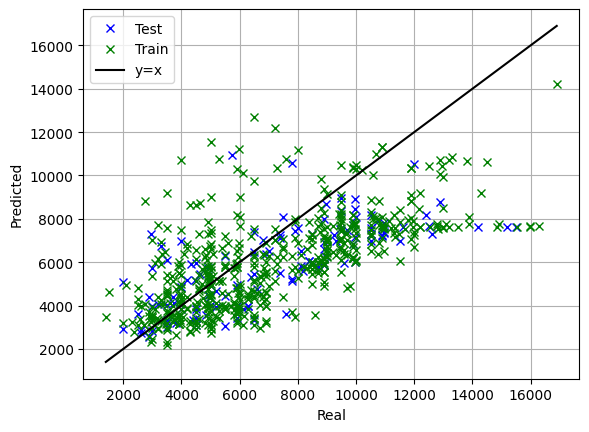

In [78]:
model_5 = LinearRegression(
    x_train, y_train,
    x_test, y_test,
    kv_l2_nn.get_best_model(), f"Neural Network with L2 regularization and lambda {kv_l2_nn.get_best_hyperparameter()}",
    flags
)

models.append(model_5.compute_metrics())

model_5.plot_pred_vs_real()
model_5.compute_metrics()

Conclusiones...

---
## 6. Conclusiones Finales

Mostramos a continuación los resultados de todos los modelos obtenidos ordenando según el `RMSE`:

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define model factory function
mod_5_factory_l2 = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=10000, solver='lbfgs')
)

# Define parameter grid
l_range = np.logspace(-5, 0, 20)
param_grid = {'mlpregressor__alpha': l_range}  # Use 'mlpregressor__alpha' to reference the model inside the pipeline

# Grid search setup
grid_search = GridSearchCV(mod_5_factory_l2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
                           return_train_score=True)

# Fit the grid search on data
grid_search.fit(x_train, y_train)

# To get best parameters:
print(grid_search.best_params_)


{'mlpregressor__alpha': np.float64(0.01438449888287663)}


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_mlpregressor__alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


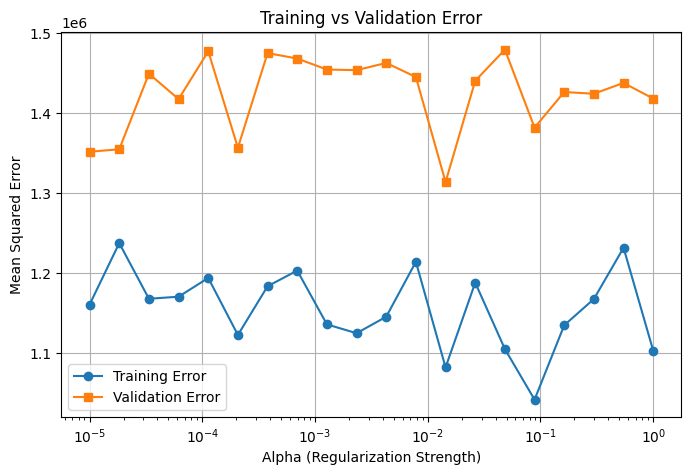

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Get alpha values from param_grid
alphas = results['param_mlpregressor__alpha'].data.astype(float)

print(results.keys())
# Extract mean training and validation errors (convert negative MSE to positive)
train_scores = -results['mean_train_score']
val_scores = -results['mean_test_score']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_scores, label='Training Error', marker='o')
plt.plot(alphas, val_scores, label='Validation Error', marker='s')

# Log scale for better visualization
plt.xscale('log')

# Labels and legend
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Error')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
models.sort("RMSE_test", ascending=True)
models.print()

,Name,RMSE_train,RMSE_test
5,Lasso Regression with lambda 1.0,1144.38,1130.31
1,Polynomial Regression of degree 2,1164.70,1132.26
3,Polynomial Regression of degree 2,1164.70,1132.26
2,Polynomial Regression of degree 2,1164.70,1132.26
4,Polynomial Regression of degree 2,1164.70,1132.26
6,Ridge Regression with lambda 1.0,1147.15,1136.74
7,Neural Network without hidden layers,1315.38,1231.45
8,Neural Network with a hidden layers of 100 neu...,1315.33,1231.73
0,Basic Linear Regression,1315.23,1232.98
9,Neural Network with L2 regularization and lamb...,2535.91,2533.42


Conclusiones...